# Determine Optimal Spectral Resolution

For a given dataset, we want to calculate the optimal spectral resolution to maximize the signal to noise ratio in a given channel while sampling the line profile sufficiently that a reasonable line centroid can be measured. In this Notebook we use forward model a given line profile to optimize the resolution.

In [1]:
%matplotlib inline
from bettermoments.methods import quadratic
import matplotlib.pyplot as plt
import numpy as np

Define the line profile you want in the function below. Here we've just used a Gaussian for ease but this can be anything you want.

In [2]:
def line_profile(x, x0, dx=1.0, A=1.0, dA=None, kernel=[0.25, 0.5, 0.25], N=10):

    # Resample the line profile at a higher resolution.

    xx = np.linspace(x[0], x[-1], x.size * N)
    yy = A * np.exp(-np.power((xx-x0)/dx, 2.0))
    y = np.array([np.average(yy[i*N:(i+1)*N]) for i in range(x.size)])

    # Convolve them with a spectral response function. For more info:
    # https://safe.nrao.edu/wiki/pub/Main/ALMAWindowFunctions/Note_on_Spectral_Response.pdf
    # A basic Hanning kernel is [0.25, 0.5, 0.25].

    if kernel is not None:
        y = np.convolve(y, kernel, mode='same')

    # Include white noise across the channels.

    if dA is not None:
        y += dA * np.random.randn(y.size)

    return y

Define the observed data and some expected properties of the line.

In [3]:
dV = 250.    # Expected Doppler line width in [m/s].
Tb = 30.     # Expected line peak in [Jy/beam or K]
chan = 30.   # Channel width in [same as dV].
RMS = 10.    # RMS noise in a line free channel [same as Tb].

In [4]:
# Build the axis for rebinning. We only want to go from
# 1 (no binning) up to a width that is 1.5 x the width.
# Include buffer values for the convolution.

Naxis = np.linspace(1.0, 1.5 * dV / chan, 100)
Naxis = np.concatenate([Naxis[:1], Naxis[:1], Naxis,
                        Naxis[-1:], Naxis[-1:]])

x0, dx0 = [], []
for N in Naxis:
    
    # Build a resonable x axis (+\- 3 x dV) around the center.
    # Adjust the noise per channel assuming white noise.

    xaxis = np.arange(-3.0 * dV, 3.0 * dV, N * chan)
    RMS_temp = RMS / np.sqrt(N)
    
    x0_samples = []
    dx0_samples = []

    # For multiple samples, vary the line center location relative
    # to the channel and measure the line center and its uncertainty.
    
    for _ in range(500):
        
        x0_temp = 2.0 * (np.random.random() - 0.5) * N * chan
        y = line_profile(xaxis, x0_temp, dV, Tb, RMS_temp)
        res = quadratic(y, x0=xaxis[0],dx=N*chan, uncertainty=RMS_temp)[:2]
        x0_samples += [abs(res[0] - x0_temp)]
        dx0_samples += [res[1]]
        
    x0 += [np.percentile(x0_samples, [16, 50, 84])]
    dx0 += [np.percentile(dx0_samples, [16, 50, 84])]
    
# Transform the arrays into something useful for plotting.
# Include a slight smoothing to help with the MC noise.
# Also remove the end values to remove convolution effects.

x0 = np.array(x0).T
x0 = np.array([x0[1], x0[1] - x0[0], x0[2] - x0[1]])
x0 = np.array([np.convolve(a[2:-2], [0.25, 0.5, 0.25], mode='same') for a in x0])

dx0 = np.array(dx0).T
dx0 = np.array([dx0[1], dx0[1] - dx0[0], dx0[2] - dx0[1]])
dx0 = np.array([np.convolve(a[2:-2], [0.25, 0.5, 0.25], mode='same') for a in dx0])

Naxis = Naxis[2:-2]

To find the optimum resampling value, we find for what resampling rate we have an accuracy which is equal to or less than the precision (as we don't want to underestimate our uncertainties), then within these acceptable rates, find the value which maximises the precision.

Text(0.03, 0.79, 'Optimal resampling = 3.90x.')

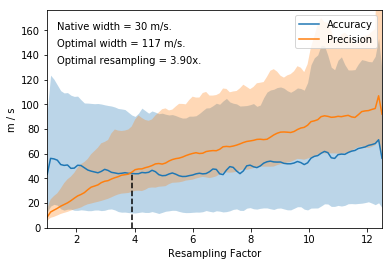

In [5]:
fig, ax = plt.subplots()

x = dV / Naxis / chan
x = Naxis

l = ax.plot(x, x0[0], label='Accuracy')
ax.fill_between(x, x0[0] - x0[1], x0[0] + x0[2], alpha=0.3,
                color=l[0].get_color(), zorder=-10, lw=0.0)

l = ax.plot(x, dx0[0], label='Precision')
ax.fill_between(x, dx0[0] - dx0[1], dx0[0] + dx0[2], alpha=0.3,
                color=l[0].get_color(), zorder=-10, lw=0.0)

ax.legend()
ax.set_xlabel(r'Resampling Factor')
ax.set_ylabel(r'm / s')

x_idx = np.where(dx0[0] >= x0[0], dx0[0], 1e10).argmin()
x_opt = x[x_idx]
ax.set_ylim(0, 4.0 * x0[0][x_idx])
ax.axvline(x_opt, ls='--', color='k', ymax=0.25)
ax.set_xlim(x[0], x[-1])

ax.text(0.03, 0.95, 'Native width = %d m/s.' % chan,
        transform=ax.transAxes, va='top', ha='left')
ax.text(0.03, 0.87, 'Optimal width = %d m/s.' % (chan * x_opt),
        transform=ax.transAxes, va='top', ha='left')
ax.text(0.03, 0.79, 'Optimal resampling = %.2fx.' % x_opt,
        transform=ax.transAxes, va='top', ha='left')